#**Pronóstico de ventas para productos Agroindustriales**
### EDA para el dataset de productos agroindustriales

Maribel Medina Arboleda \
Manuel Alberto Peñafiel Mendoza \
Carlos Alberto Lenguerque Moreno \

El conjunto de datos con el que se desarrolló el proyecto es una base de datos otorgada por la empresa Energía y Potencia SAS, empresa comercializadora de productos para el agro a nivel nacional

Histórico de ventas de cada producto desde el año 2014
Variable respuesta: Ventas en unidades
Variables explicativas: Año y mes de ventas, Producto, Stock 

In [1]:
!pip install feature_engine

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as ss

import missingno as msno    #Paquete de visualización de valor perdido
from feature_engine.discretisation import EqualFrequencyDiscretiser
from feature_engine.encoding import OrdinalEncoder
from feature_engine.imputation import CategoricalImputer
from feature_engine.imputation import MeanMedianImputer


from pandas.plotting import scatter_matrix

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Análisis Exploratorio de Datos e Ingeniería de Características**

In [5]:
Maquinas = pd.read_csv('/content/drive/MyDrive/Estadistica Multivariada/Proyecto/ParetoMaquinas.csv', encoding = "latin-1")

In [6]:
# Tipo de Variables
Maquinas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17016 entries, 0 to 17015
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Fecha          17016 non-null  object
 1   sk_referencia  17016 non-null  int64 
 2   Division       17016 non-null  object
 3   Subdivision    17016 non-null  object
 4   Stock          17016 non-null  int64 
 5   Ventas         17016 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 797.8+ KB


In [7]:
# Pasamos la columna de Fecha a tipo fecha
Maquinas['Fecha'] = pd.to_datetime(Maquinas['Fecha'], format="%Y/%m/%d")

In [8]:
Maquinas.head().append(Maquinas.tail())

,Fecha,sk_referencia,Division,Subdivision,Stock,Ventas
0,2014-01-01,1584,DIVISION MOTRIZ,MOTORES ELECTRICOS,0,2
1,2014-01-01,1720,DIVISION MOTRIZ,MOTORES DIESEL INDUSTRIALES,0,1
2,2014-01-01,1721,DIVISION MOTRIZ,MOTORES DIESEL INDUSTRIALES,0,1
3,2014-01-01,1727,DIVISION MOTRIZ,MOTORES DIESEL INDUSTRIALES,0,1
4,2014-01-01,1729,DIVISION MOTRIZ,MOTORES DIESEL INDUSTRIALES,0,1
17011,2021-09-01,39072,DIVISION ENERGIA,GENERADORES DIESEL INDUSTRIALES,0,1
17012,2021-09-01,39088,DIVISION ENERGIAS ALTERNATIVAS,CONTROLADORES,0,1
17013,2021-09-01,39167,DIVISION MOTRIZ,MOTORES GASOLINA,1,1
17014,2021-09-01,39277,DIVISION ENERGIAS ALTERNATIVAS,INVERSORES,7,1
17015,2021-09-01,39284,DIVISION ENERGIA,GENERADORES GASOLINA,0,2


In [9]:
# Registros y variables contenidas en el dataset
Maquinas.shape

(17016, 6)

In [10]:
# Resumen de las variables numéricas
Maquinas.describe()

,sk_referencia,Stock,Ventas
count,17016.000000,17016.000000,17016.000000
mean,27694.910085,47.285437,15.770334
std,7256.551125,162.907789,59.163038
min,1584.000000,0.000000,0.000000
25%,25946.000000,1.000000,1.000000
50%,27964.000000,7.000000,3.000000
75%,32634.000000,29.000000,11.000000
max,39284.000000,3296.000000,2121.000000


In [11]:
# Número de referencias únicas (SKU) 

SKU= (Maquinas.groupby('sk_referencia')['Fecha'].nunique())
pdSKU= pd.DataFrame(SKU)
pdSKU.sort_values('Fecha',ascending=False)

,Fecha
sk_referencia,
34960,93
6013,93
37074,93
5996,92
30202,92
...,...
26821,1
26825,1
26832,1


In [12]:
tabla = pdSKU[(pdSKU["Fecha"] >= 89)]
tabla

,Fecha
sk_referencia,
4194,91
5996,92
6000,91
6009,92
6013,93
22674,89
24320,89
24331,91
25922,92


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf15999210>]],
      dtype=object)

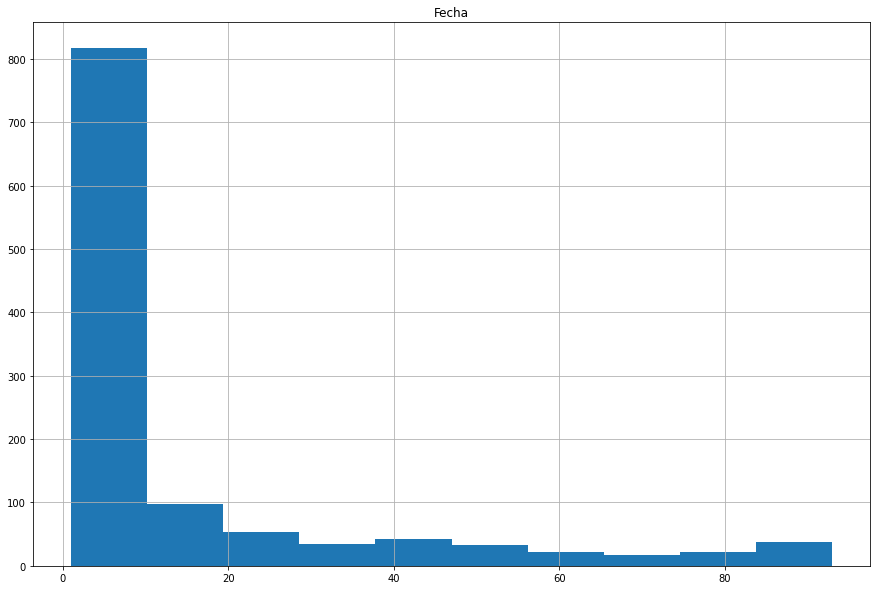

In [15]:
# El dataset de Máquinas cuenta con información de stock y de ventas desde el año 2.014 a septeimbre de 2021
# Evaluemos la cantidad de información y el número de SKUs (código único de producto) con los que vamos a trabajar con base en el número suficiente de observaciones:
pdSKU.hist(figsize=(15,10))

Observamos que el número de referencias con datos completos es muy bajo

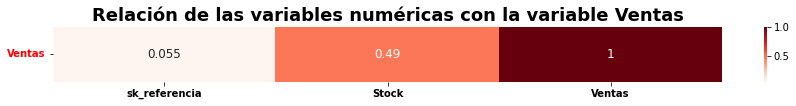

In [16]:
# Relación del stock  con las Ventas

num = Maquinas.select_dtypes(exclude='object')

num_corr = num.corr()

#Plot the correlations

f, ax = plt.subplots(figsize=(15,1))

sns.heatmap(num_corr.sort_values(by=['Ventas'], ascending=False).head(1), cmap='Reds',annot_kws = {"size": 12},annot = True)
plt.title('Relación de las variables numéricas con la variable Ventas', weight='bold', fontsize=18)
plt.xticks(weight='bold')
plt.yticks(weight='bold', color='red', rotation=0)
plt.show()

Observamos que la correlación de la variable stock no es tan fuerte. Es importante para un trabajo futuro evaluar la correlación con otras variables exógenas como: la tasa representativa del mercado, valor de fletes, leadtime de los productos, inversión en mercadeo, entre otros

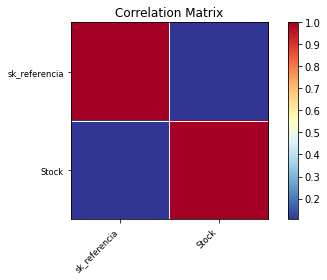

In [17]:
corr = Maquinas.set_index('Ventas').corr()
sm.graphics.plot_corr(corr, xnames=list(corr.columns))
plt.show()

In [18]:
num_corr = Maquinas.corr()

num_corr

,sk_referencia,Stock,Ventas
sk_referencia,1.000000,0.104757,0.055295
Stock,0.104757,1.000000,0.487743
Ventas,0.055295,0.487743,1.000000


En la exploración del set de datos para el anteproyectos observamos unas Divisiones poco representativa en las ventas, por ello, sólo tomamos el pareto de productos y divisiones que más se comercializan

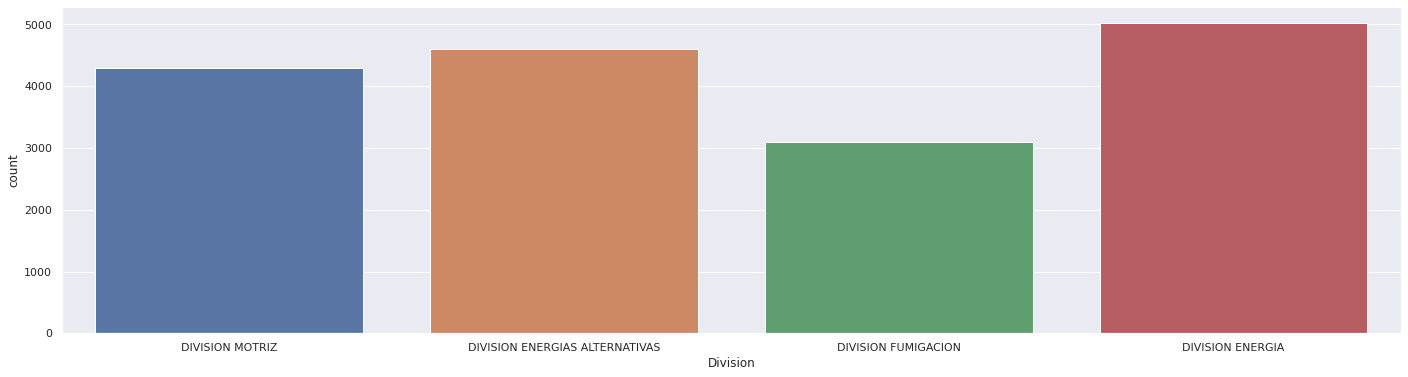

In [19]:
# Número de datos por unidad de negocio
plt.figure(figsize=(24, 6))
sns.set(style="darkgrid",)
sns.countplot(x='Division', data=Maquinas)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:4018: RuntimeWarning: divide by zero encountered in log
  trm = _norm_pdf(a + b * np.log(x + np.sqrt(x2+1)))
/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:1702: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for

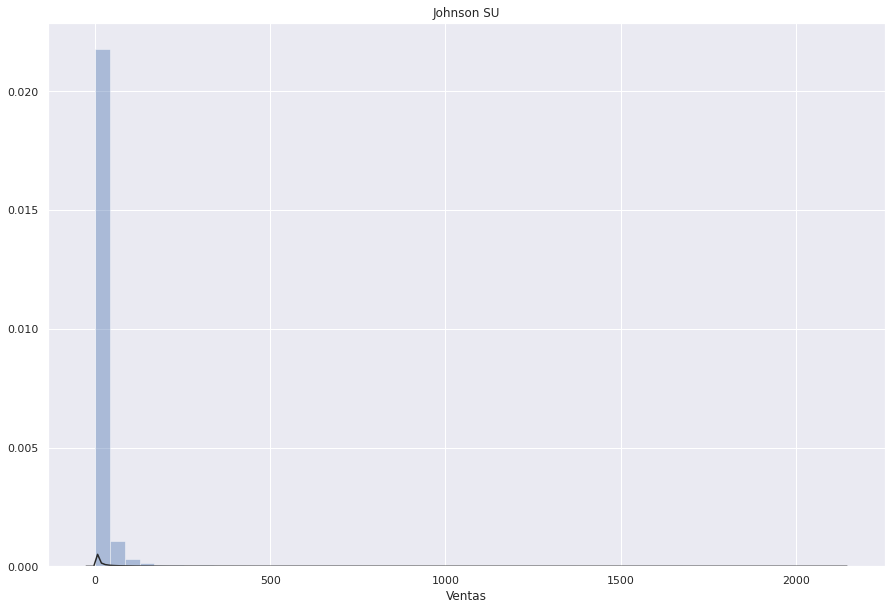

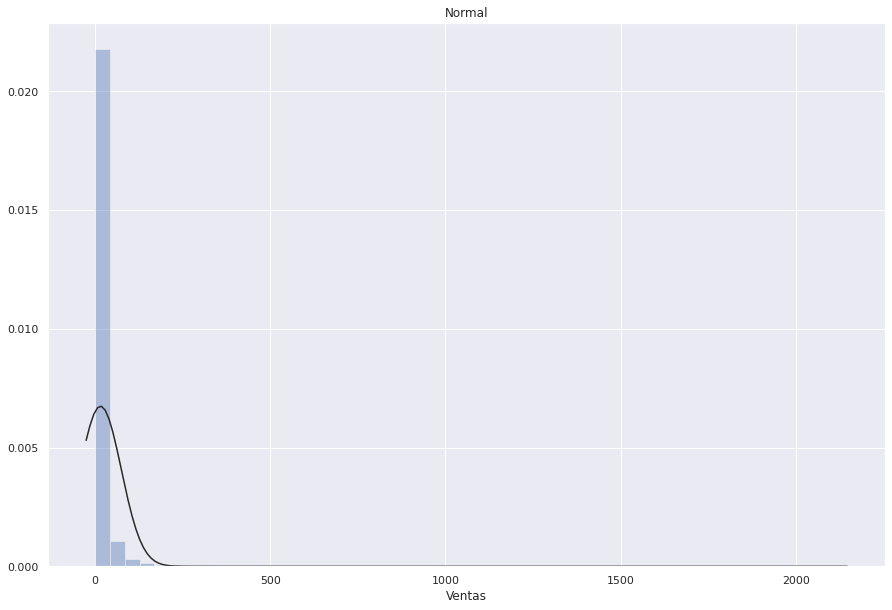

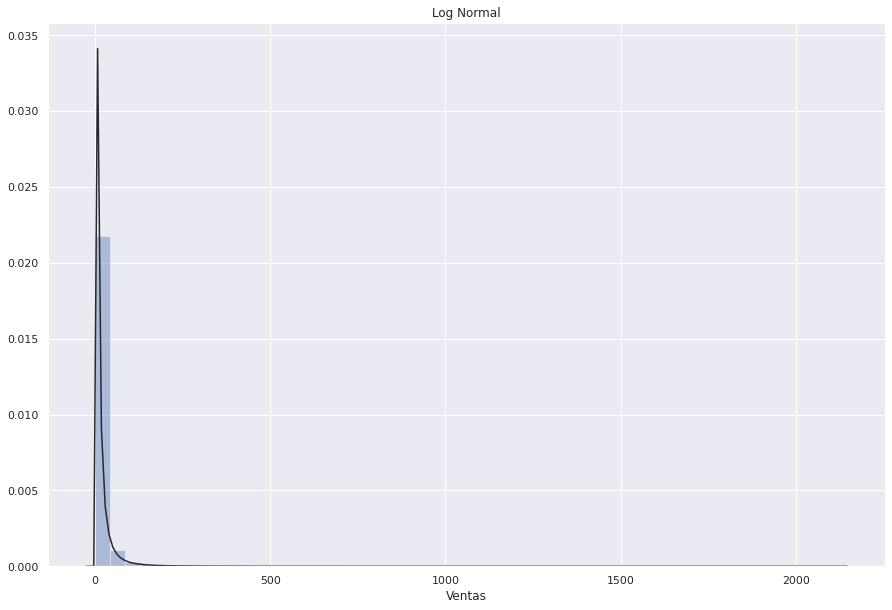

In [20]:
# Distribucion de la variable respuesta

y = Maquinas['Ventas']
plt.figure(1, figsize=(15,10)); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=ss.johnsonsu)
plt.figure(2,figsize=(15,10)); plt.title('Normal')
sns.distplot(y, kde=False, fit=ss.norm)
plt.figure(3,figsize=(15,10)); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=ss.lognorm)

Una vez seleccionada las 4 divisiones que contienen el pareto de las ventas de los productos, se realizó una evaluación de la distribución de las ventas, donde se observa que su distribución tiene una distribución no normal y más logarítmica

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Asimetría: 15.705513
Curtosis: 381.632567


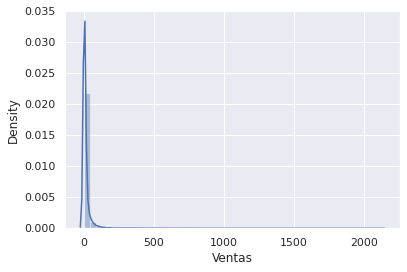

In [23]:
sns.distplot(Maquinas['Ventas']);
print("Asimetría: %f" % Maquinas['Ventas'].skew())
print("Curtosis: %f" % Maquinas['Ventas'].kurt())

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


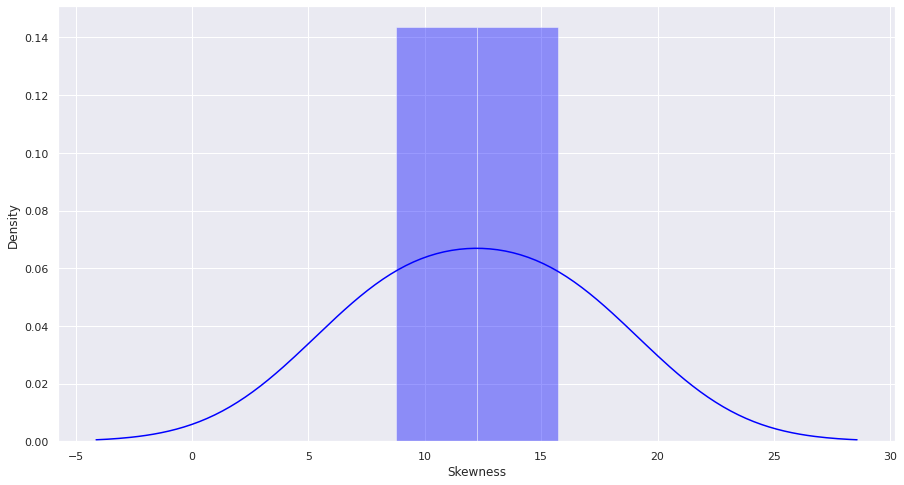

In [52]:
sns.distplot(Maquinas.skew(),color='blue',axlabel ='Skewness')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


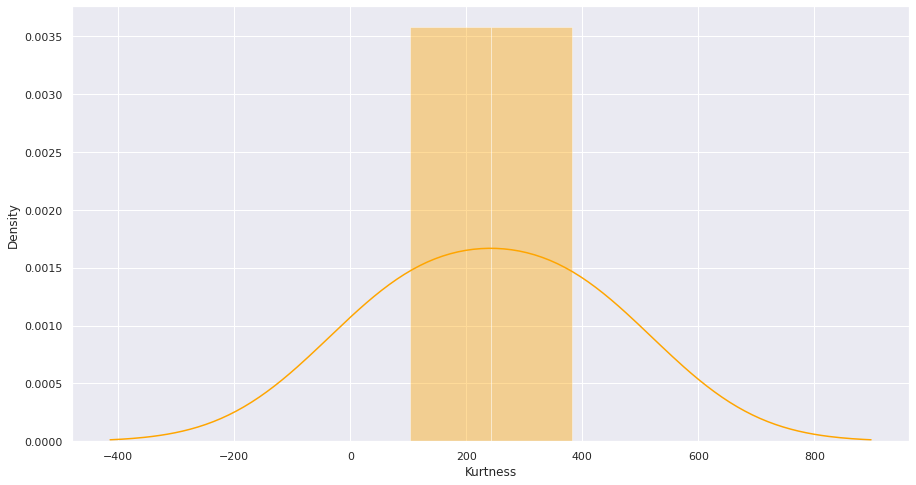

In [53]:
sns.distplot(Maquinas.kurt(),color='orange',axlabel ='Kurtness')

###Convirtiendo la columna División y Subdivisión en categórica y la columna sk_producto en string, en caso que algún modelo lo requiera

In [25]:
Maquinas['sk_referencia'] = Maquinas['sk_referencia'].astype('string')

In [45]:
# set up the encoder
encoder = OrdinalEncoder(encoding_method='arbitrary',
  variables=['Division','Subdivision'])
 
# fit the encoder
encoder.fit(Maquinas)
 
# transform the data
Datos_salida= encoder.transform(Maquinas)

### **Visualización de datos faltantes en el conjunto de datos**

In [46]:
# Gráfica de datos faltantes por variable
sns.set(rc={'figure.figsize':(15,8)})
missing = Datos_salida.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
len(missing)

0

Observamos que el set de datos no contiene datos faltantes

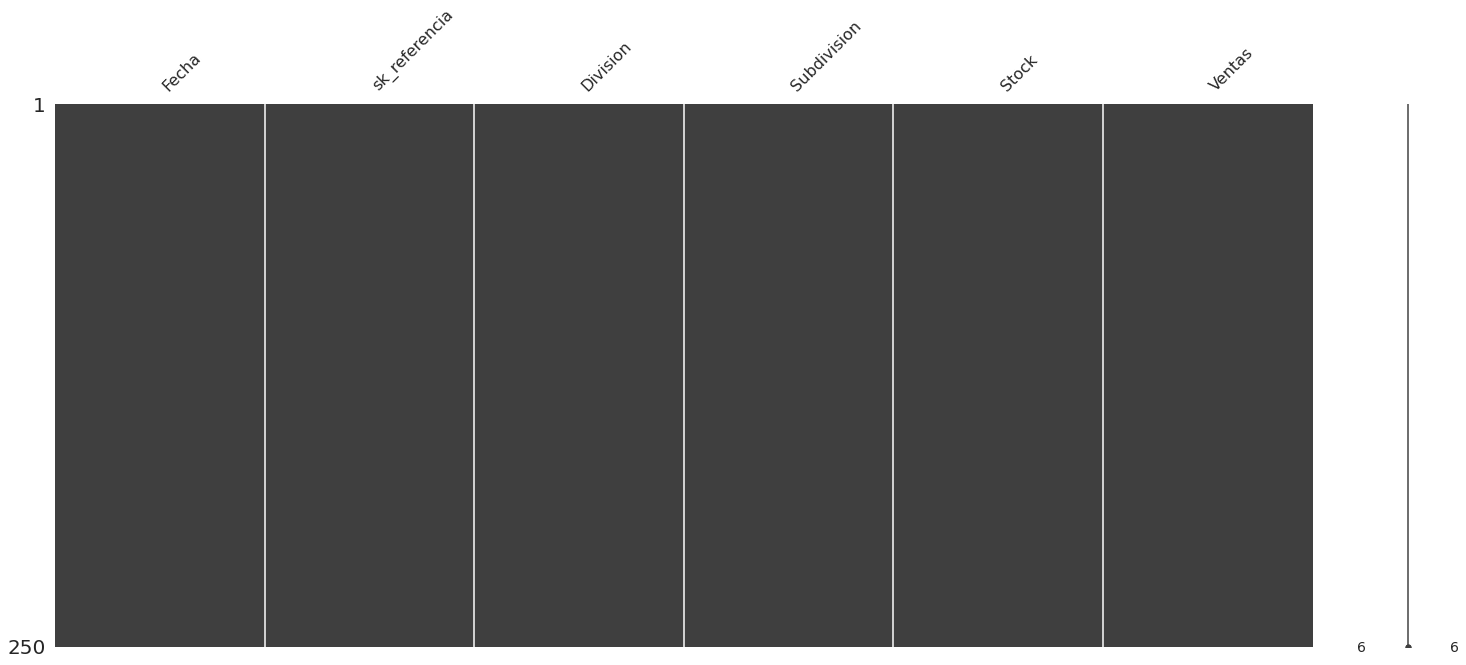

In [48]:
msno.matrix(Datos_salida.sample(250))

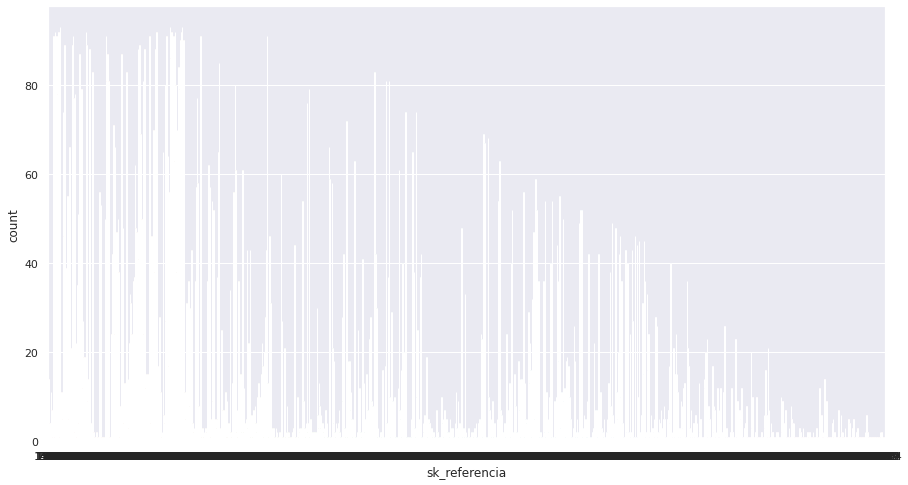

In [49]:
# Número de datos por clasificación de referencia
sns.set(rc={'figure.figsize':(15,8)})
sns.set(style="darkgrid")
sns.countplot(x='sk_referencia', data=Datos_salida)

In [50]:
# Para la variable numérica ventas, se reemplazaran los datos faltantes por la media para que no cambie los valores
media_imputer = MeanMedianImputer(imputation_method='mean',
  variables=['Ventas'])
 
# fit the imputer
media_imputer.fit(Datos_salida)
 
# transform the data
Datos_salida= media_imputer.transform(Datos_salida)

In [51]:
Datos_salida.head().append(Datos_salida.tail())

,Fecha,sk_referencia,Division,Subdivision,Stock,Ventas
0,2014-01-01,1584,0,0,0,2
1,2014-01-01,1720,0,1,0,1
2,2014-01-01,1721,0,1,0,1
3,2014-01-01,1727,0,1,0,1
4,2014-01-01,1729,0,1,0,1
17011,2021-09-01,39072,3,16,0,1
17012,2021-09-01,39088,1,3,0,1
17013,2021-09-01,39167,0,4,1,1
17014,2021-09-01,39277,1,27,7,1
17015,2021-09-01,39284,3,9,0,2


In [57]:
Caracteristicas_numericas = Datos_salida[['Ventas', 'Stock']]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


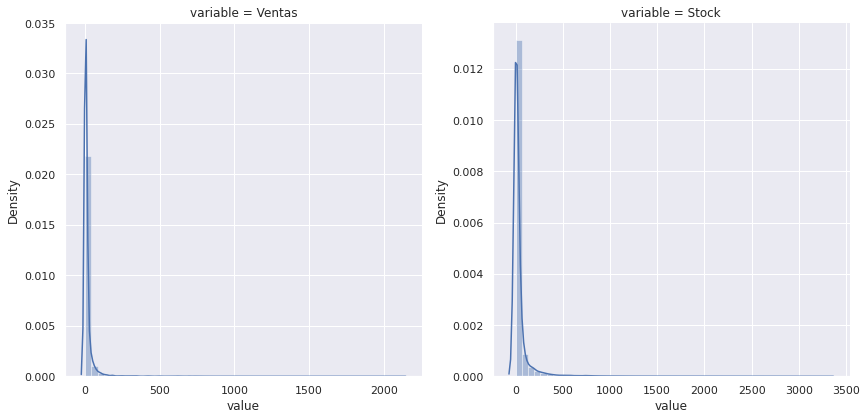

In [58]:
## Visualización de la distribución de cada variable numérica
sns.set(rc={'figure.figsize':(30,8)})
f = pd.melt(Caracteristicas_numericas, value_vars=Caracteristicas_numericas)
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False, height=6, aspect=1)
g = g.map(sns.distplot, "value")

### **Exportar el nuevo set de datos a Excel**

In [61]:
Datos_salida.to_excel('/content/drive/MyDrive/Estadistica Multivariada/Proyecto/VentasMaquinas.xlsx')